<h1>0. Imports</h1>

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import scipy
import math

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

<h1>1. Data Exploration

<h2>
1a. Functions for data importing and for location comparison

In [2]:
def import_data(location):

    insitu = pd.read_csv('data/' + location + '/insitu.csv')
    insitu['date_time'] = pd.to_datetime(insitu['date_time'])
    insitu = insitu.set_index('date_time')

    reanalysis = pd.read_csv('data/' + location + '/reanalysis.csv')
    reanalysis['date_time'] = pd.to_datetime(reanalysis['Unnamed: 0'])
    reanalysis = reanalysis.set_index('date_time')
    reanalysis = reanalysis.drop(columns = ['Unnamed: 0'])

    satellite = pd.read_csv('data/' + location + '/satellite.csv')
    satellite['date_time'] = pd.to_datetime(satellite['Unnamed: 0'])
    satellite = satellite.set_index('date_time')
    satellite = satellite.drop(columns = ['Unnamed: 0'])
    
    return insitu, reanalysis, satellite



def data_corr(insitu, reanalysis, satellite, pairplot = False):

    # Sample up all datasets to daily data
    # (Should also look at flags, but for now it's fine)
    
    insitu_daily_mean = insitu['soil_moisture'].resample('1D').mean()    
    
    reanalysis_daily_mean = reanalysis[['swvl1','swvl2','swvl3','swvl4']].resample('1D').mean()
    # Weighted average based on the layer information(https://codes.ecmwf.int/grib/param-db/39) and the instrument depth information of the in situ data (usually 0.05 - 0.1m, Germany 0.25m)
    reanalysis_daily_mean['swvl_mean'] = reanalysis_daily_mean['swvl1']*0.4 + reanalysis_daily_mean['swvl2']*0.4 + reanalysis_daily_mean['swvl3']*0.05 + reanalysis_daily_mean['swvl4']*0.05
    reanalysis_daily_mean = reanalysis_daily_mean['swvl_mean']
    
    satellite_daily_mean = satellite['sm']

    
    # Find out the days where all 3 datasets have data and only use those days for the correlation
    days_3_measurements = np.array([])
    for day in insitu_daily_mean.index:
        if (day in reanalysis_daily_mean.index) & (day in satellite_daily_mean.index):
            if np.any([np.isnan(insitu_daily_mean[day]), np.isnan(reanalysis_daily_mean[day]), np.isnan(satellite_daily_mean[day])]):
                continue
            else:
                days_3_measurements = np.append(days_3_measurements, [day])
    
    # Put all 3 datasets into one dataframe
    corr_data = pd.DataFrame(data = {"insitu": insitu_daily_mean[days_3_measurements],
                                          "reanalysis": reanalysis_daily_mean[days_3_measurements],
                                          "satellite": satellite_daily_mean[days_3_measurements]}, 
                                   index = days_3_measurements)

    # Plot the seaborn pairplot if requested
    if pairplot:
        pairplot = sns.pairplot(data = corr_data)

    # Calculate correlations
    pearson_r_list = [] # Linear relationship
    pearson_r_list.append(scipy.stats.pearsonr(corr_data["insitu"], corr_data["reanalysis"])[0])
    pearson_r_list.append(scipy.stats.pearsonr(corr_data["insitu"], corr_data["satellite"])[0])
    pearson_r_list.append(scipy.stats.pearsonr(corr_data["satellite"], corr_data["reanalysis"])[0])

    spearman_r_list = [] # Monotonous (rank-based) relationship
    spearman_r_list.append(scipy.stats.spearmanr(corr_data["insitu"], corr_data["reanalysis"])[0])
    spearman_r_list.append(scipy.stats.spearmanr(corr_data["insitu"], corr_data["satellite"])[0])
    spearman_r_list.append(scipy.stats.spearmanr(corr_data["satellite"], corr_data["reanalysis"])[0])

    r2_list = [] # coefficient of determination (how much of the error is explained by the variance?)
    r2_list.append(sklearn.metrics.r2_score(corr_data["insitu"], corr_data["reanalysis"]))
    r2_list.append(sklearn.metrics.r2_score(corr_data["insitu"], corr_data["satellite"]))
    r2_list.append(sklearn.metrics.r2_score(corr_data["satellite"], corr_data["reanalysis"]))

    corr_df = pd.DataFrame(data = {"pearson_r": pearson_r_list, "spearman_r": spearman_r_list, "r2": r2_list}, index = ["insitu_reanalysis", "insitu_satellite", "satellite_reanalysis"]) 
    
    return corr_df

<h2>1b. Compare the correlation between the datasets in different locations

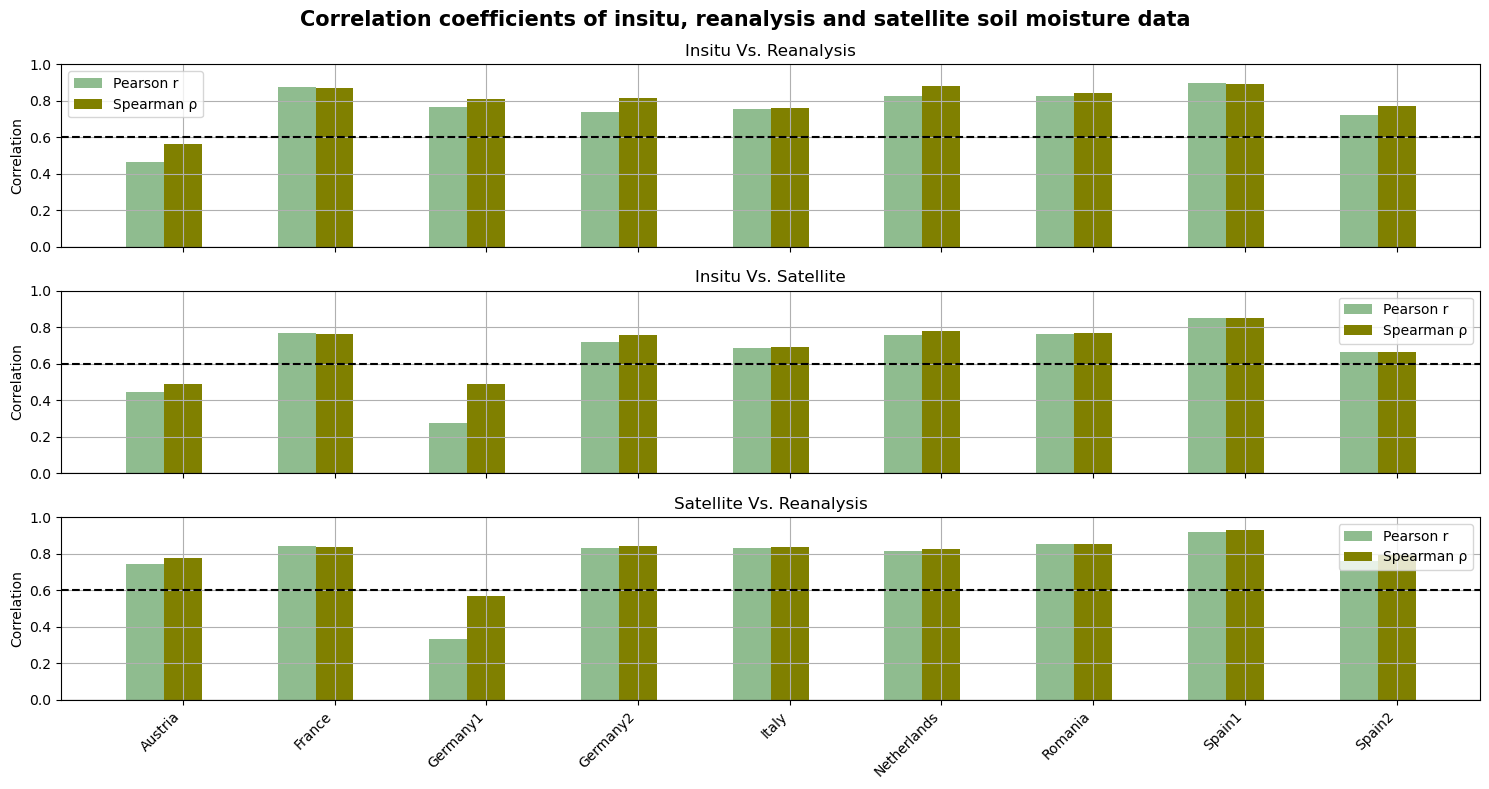

In [3]:
locations = ['Austria_lat=48.15426_lon=15.14975',
            'France_lat=43.4417_lon=1.88',
             'Germany1_lat=50.39428_lon=7.60313',
             'Germany2_lat=50.9303_lon=6.29747',
            'Italy_lat=44.68277_lon=8.62669',
             'Netherlands_lat=52.19389_lon=6.4175',
             'Romania_lat=44.47617_lon=23.1129',
             'Spain1_lat=41.20548_lon=-5.41558',
             'Spain2_lat=42.42841_lon=1.1244'
            ]

fig, ax = plt.subplots(3,1, figsize = (15,8), sharex = True)

rows = []
for location in locations:
    insitu, reanalysis, satellite = import_data(location)
    corr_df = data_corr(insitu, reanalysis, satellite, pairplot = False)
    for pair in corr_df.index:
        rows.append({
            "location": location,
            "pair": pair,
            "pearson": corr_df.loc[pair, "pearson_r"],
            "spearman": corr_df.loc[pair, "spearman_r"],
            "r2": corr_df.loc[pair, "r2"]
        })

corr_all = pd.DataFrame(rows)


pairs = corr_all["pair"].unique()
metrics = ["pearson", "spearman", "r2"]

x = np.arange(len(locations))
width = 0.25

for i, pair in enumerate(pairs):
    subset = (
        corr_all[corr_all["pair"] == pair]
        .set_index("location")
        .reindex(locations)
    )

    ax[i].bar(x - width, subset["pearson"],  width, label="Pearson r", color = 'darkseagreen')
    ax[i].bar(x,         subset["spearman"], width, label="Spearman ρ", color = 'olive')
    #ax[i].bar(x + width, subset["r2"],  width, label="r2")

    ax[i].set_title(pair.replace("_", " vs. ").title())
    ax[i].set_ylabel("Correlation")
    ax[i].axhline(0, color="k", linewidth=0.8)
    ax[i].legend()
    ax[i].set_ylim(0,1)
    ax[i].axhline(0.6, c = 'black', linestyle = 'dashed')
    ax[i].grid()

ax[-1].set_xticks(x)
labels = [location.split('_')[0] for location in locations]
ax[-1].set_xticklabels(labels, rotation=45, ha="right")

fig.suptitle('Correlation coefficients of insitu, reanalysis and satellite soil moisture data', fontsize = 15, weight = 'bold')

plt.tight_layout()
plt.show()

<h2>1c. Compare the satellite gap patterns in well-correlating locations

Text(0.5, 0.98, 'Soil moisture satellite time series at different locations)')

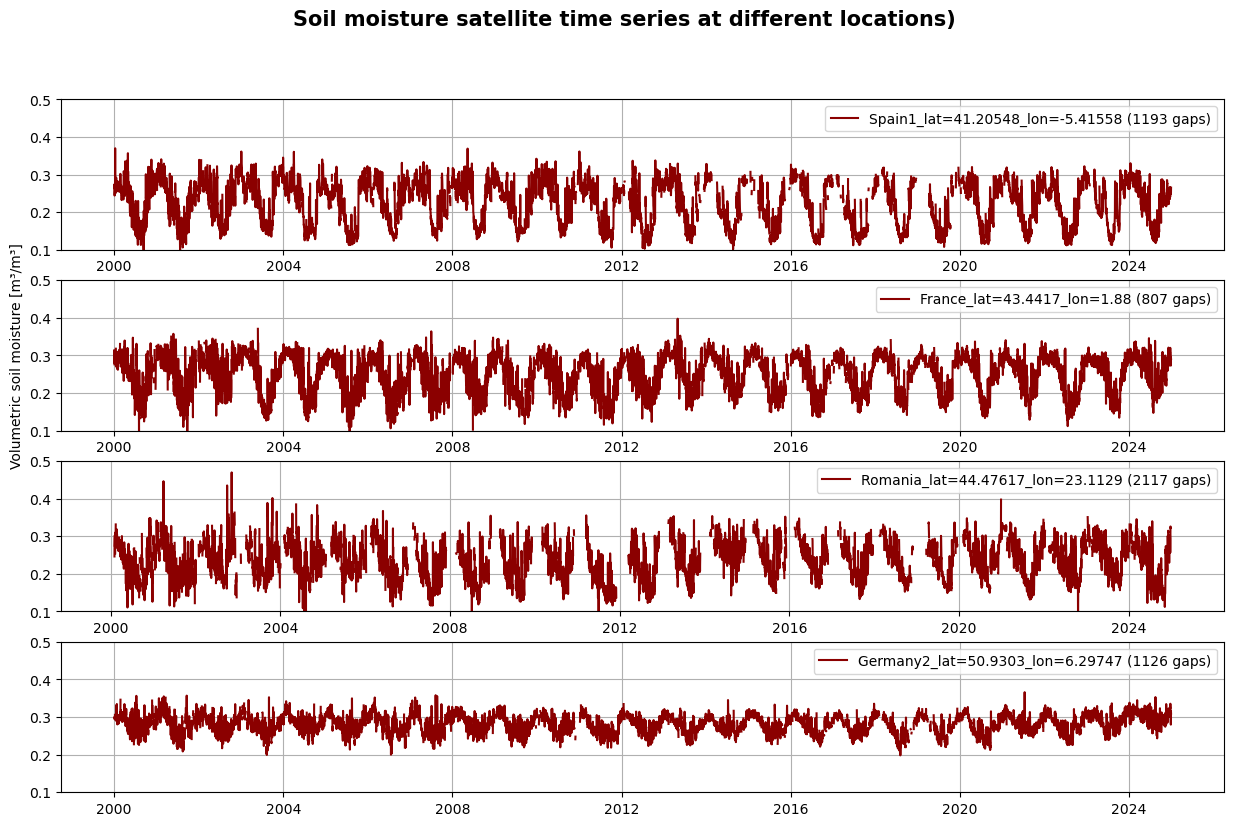

In [4]:
locations = ['Spain1_lat=41.20548_lon=-5.41558', 
            'France_lat=43.4417_lon=1.88',
            'Romania_lat=44.47617_lon=23.1129',
             'Germany2_lat=50.9303_lon=6.29747']

ymax = 0.5
ymin = 0.1

fig, ax = plt.subplots(4,1,figsize = (15,9))


for i, location in enumerate(locations):

    _, _, satellite = import_data(location)

    data_gaps = len(satellite[satellite['sm'].isna()])

    ax[i].plot(satellite['sm'], c = 'darkred', label = f'{location} ({data_gaps} gaps)')
    if i == 1:
        ax[i].set_ylabel('Volumetric soil moisture [m³/m³]')
    ax[i].grid()
    ax[i].legend()
    ax[i].set_ylim(ymin, ymax)

fig.suptitle(f'Soil moisture satellite time series at different locations)', weight = 'bold', fontsize = 15)

<h2>
1d. Basic data exploration

In [5]:
#location = 'Spain1_lat=41.20548_lon=-5.41558'
location = 'Romania_lat=44.47617_lon=23.1129'
insitu, reanalysis, satellite = import_data(location)

Text(0.5, 1.0, "ERA5-Land reanalysis Soil moisture time series at location 'Romania_lat=44.47617_lon=23.1129' (original 6h timesteps)")

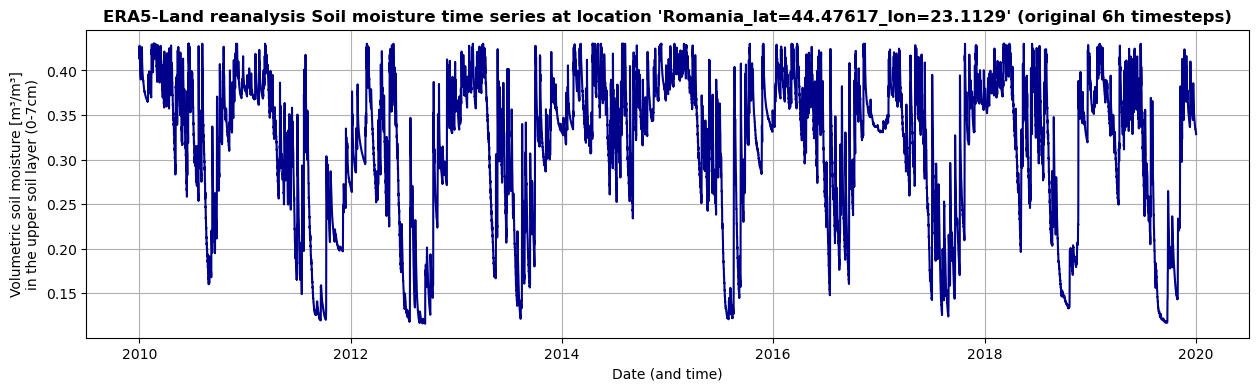

In [6]:
# Show the original time series
fig, ax = plt.subplots(1,1,figsize = (15,4))
ax.plot(reanalysis['swvl1'].loc['2010-01-01':'2020-01-01'], c = 'darkblue')
ax.set_xlabel('Date (and time)')
ax.set_ylabel('Volumetric soil moisture [m³/m³]\nin the upper soil layer (0-7cm)')
ax.grid()
ax.set_title(f'ERA5-Land reanalysis Soil moisture time series at location \'{location}\' (original 6h timesteps)', weight = 'bold')

Text(0.5, 0.98, "Soil moisture time series section at location \n'Romania_lat=44.47617_lon=23.1129' \n(daily mean)")

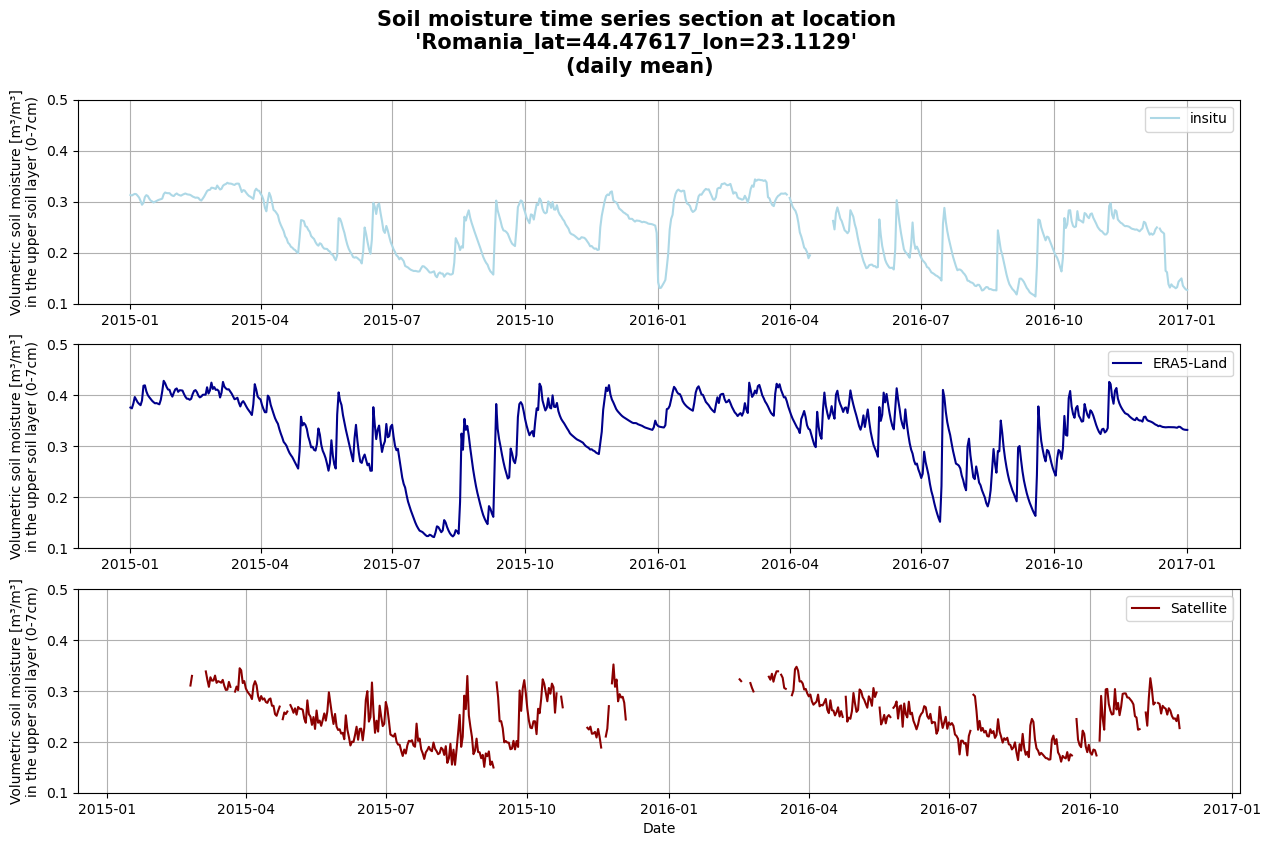

In [7]:
# Show daily mean time series
insitu_daily = insitu['soil_moisture'].resample('1D').mean()  
reanalysis_daily = reanalysis.resample('1D').mean()
satellite_daily = satellite

ymax = 0.5
ymin = 0.1


fig, ax = plt.subplots(3,1,figsize = (15,9))

ax[0].plot(insitu_daily.loc['2015-01-01':'2017-01-01'], c = 'lightblue', label = 'insitu')
ax[0].set_ylabel('Volumetric soil moisture [m³/m³]\nin the upper soil layer (0-7cm)')
ax[0].grid()
ax[0].legend()
ax[0].set_ylim(ymin, ymax)

ax[1].plot(reanalysis_daily['swvl1'].loc['2015-01-01':'2017-01-01'], c = 'darkblue', label = 'ERA5-Land')
ax[1].set_ylabel('Volumetric soil moisture [m³/m³]\nin the upper soil layer (0-7cm)')
ax[1].grid()
ax[1].legend()
ax[1].set_ylim(ymin, ymax)

ax[2].plot(satellite_daily['sm'].loc['2015-01-01':'2017-01-01'], c = 'darkred', label = 'Satellite')
ax[2].set_ylabel('Volumetric soil moisture [m³/m³]\nin the upper soil layer (0-7cm)')
ax[2].grid()
ax[2].set_xlabel('Date')
ax[2].legend()
ax[2].set_ylim(ymin, ymax)

fig.suptitle(f'Soil moisture time series section at location \n\'{location}\' \n(daily mean)', weight = 'bold', fontsize = 15)

In [8]:
# Compute basic statistics
mean = reanalysis['swvl1'].mean()
median = reanalysis['swvl1'].median()
std = reanalysis['swvl1'].std()
max = reanalysis['swvl1'].max()
min = reanalysis['swvl1'].min()

print(f'mean: {mean:.3f} m³/m³')
print(f'median: {median:.3f} m³/m³')
print(f'std: {std:.3f} m³/m³')
print(f'max: {max:.3f} m³/m³')
print(f'min: {min:.3f} m³/m³')

mean: 0.307 m³/m³
median: 0.329 m³/m³
std: 0.082 m³/m³
max: 0.430 m³/m³
min: 0.114 m³/m³


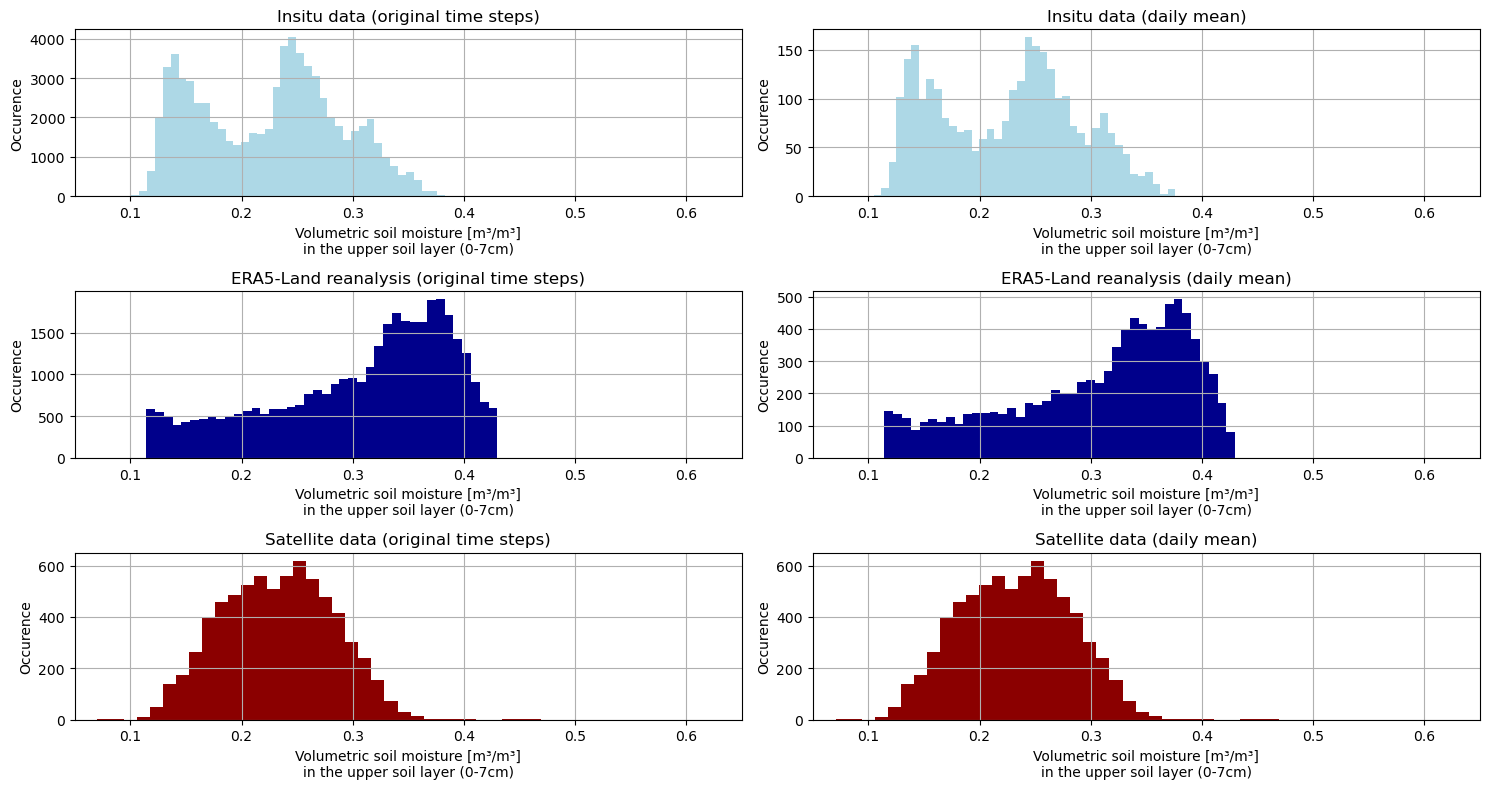

In [9]:
data_case = [[insitu['soil_moisture'], insitu_daily], [reanalysis['swvl1'], reanalysis_daily['swvl1']], [satellite['sm'], satellite['sm']]]
labels = ['Insitu data', 'ERA5-Land reanalysis', 'Satellite data']
colors = ['lightblue', 'darkblue', 'darkred']

fig, ax = plt.subplots(3,2, figsize=(15,8))

for i, dataset in enumerate(data_case):

    ax[i,0].hist(dataset[0], bins=40, color = colors[i])
    ax[i,0].set_xlabel("Volumetric soil moisture [m³/m³]\nin the upper soil layer (0-7cm)")
    ax[i,0].set_ylabel("Occurence")
    ax[i,0].grid()
    ax[i,0].set_title(f'{labels[i]} (original time steps)')
    ax[i,0].set_xlim(0.05,0.65)
    
    ax[i,1].hist(dataset[1], bins=40, color = colors[i])
    ax[i,1].set_xlabel("Volumetric soil moisture [m³/m³]\nin the upper soil layer (0-7cm)")
    ax[i,1].set_ylabel("Occurence")
    ax[i,1].grid()
    ax[i,1].set_title(f'{labels[i]} (daily mean)')
    ax[i,1].set_xlim(0.05,0.65)


plt.tight_layout()

<h2>1e. Investigate seasonalities</h2>

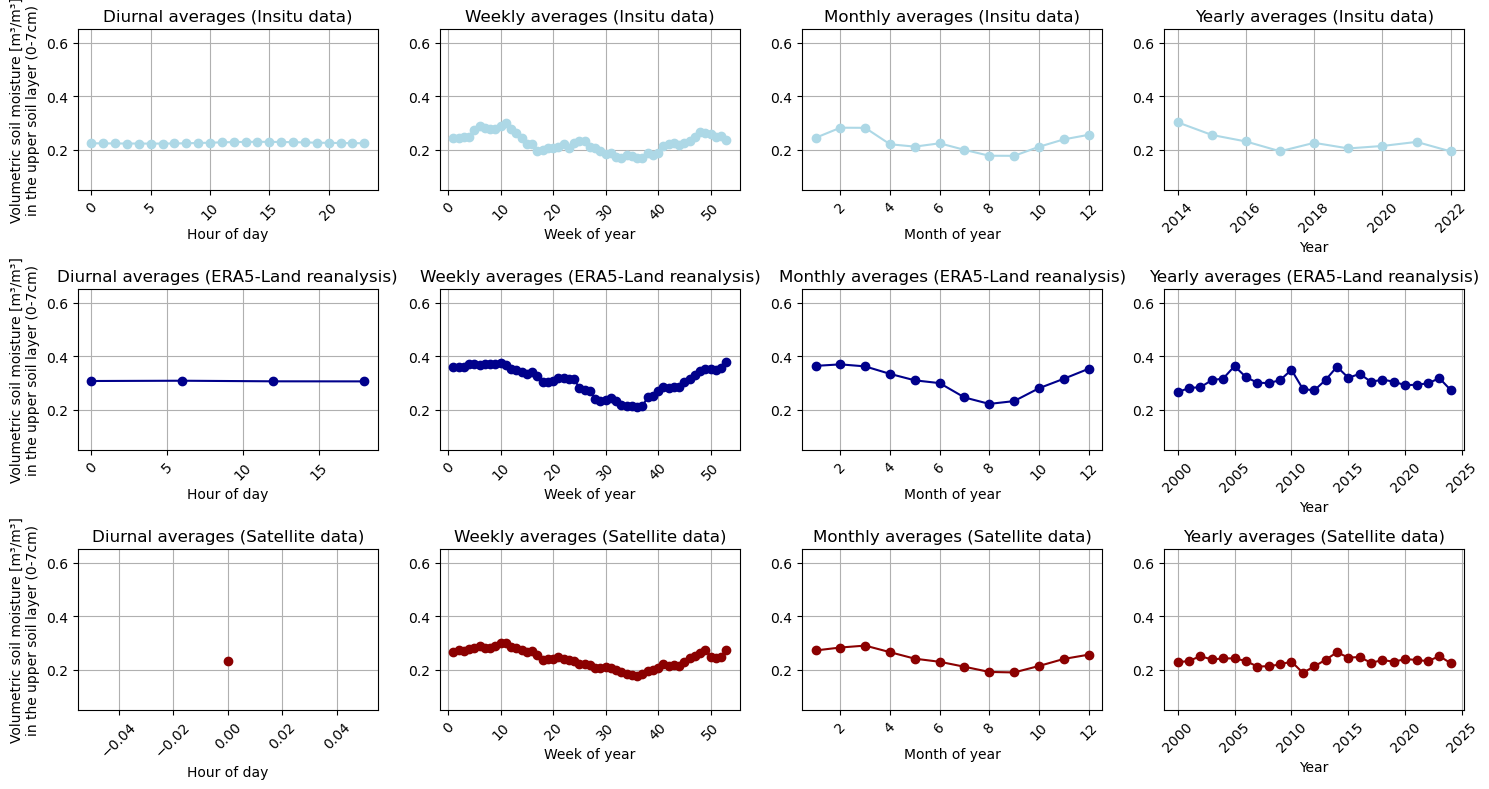

In [10]:
data_case = [[insitu['soil_moisture'], insitu_daily], [reanalysis['swvl1'], reanalysis_daily['swvl1']], [satellite['sm'], satellite['sm']]]
labels = ['Insitu data', 'ERA5-Land reanalysis', 'Satellite data']
colors = ['lightblue', 'darkblue', 'darkred']



fig, axs = plt.subplots(3,4, figsize=(15,8))

for i, dataset in enumerate(data_case):

    diurnal_mean = dataset[0].groupby(by=dataset[0].index.hour).agg("mean")
    weekly_mean = dataset[1].groupby(by=dataset[1].index.isocalendar().week).agg("mean")
    monthly_mean = dataset[1].groupby(by=dataset[1].index.month).agg("mean")
    yearly_mean = dataset[1].groupby(by=dataset[1].index.year).agg("mean")

    axs[i,0].plot(diurnal_mean.index, diurnal_mean, "-o", c = colors[i])
    axs[i,0].set_title(f"Diurnal averages ({labels[i]})")
    axs[i,0].tick_params("x", rotation=45)
    axs[i,0].set_xlabel('Hour of day')
    axs[i,0].set_ylim(0.05,0.65)
    axs[i,0].set_ylabel("Volumetric soil moisture [m³/m³]\nin the upper soil layer (0-7cm)")
    axs[i,0].grid()
    
    axs[i,1].plot(weekly_mean.index, weekly_mean, "-o", c = colors[i])
    axs[i,1].set_title(f"Weekly averages ({labels[i]})")
    axs[i,1].tick_params("x", rotation=45)
    axs[i,1].set_xlabel('Week of year')
    axs[i,1].set_ylim(0.05,0.65)
    axs[i,1].grid()
    
    axs[i,2].plot(monthly_mean.index, monthly_mean, "-o", c = colors[i])
    axs[i,2].set_title(f"Monthly averages ({labels[i]})")
    axs[i,2].tick_params("x", rotation=45)
    axs[i,2].set_xlabel('Month of year')
    axs[i,2].set_ylim(0.05,0.65)
    axs[i,2].grid()
    
    axs[i,3].plot(yearly_mean.index, yearly_mean, "-o", c = colors[i])
    axs[i,3].set_title(f"Yearly averages ({labels[i]})")
    axs[i,3].tick_params("x", rotation=45)
    axs[i,3].set_xlabel('Year')
    axs[i,3].set_ylim(0.05,0.65)
    axs[i,3].grid()

plt.tight_layout()

In [11]:
# Compute linear trend
compute_theilsenn = False

if compute_theilsenn:
    x = np.linspace(0, len(reanalysis), num=len(reanalysis))
    res = scipy.stats.theilslopes(reanalysis['swvl1'], x)
    
    fig = plt.figure(figsize = (14,5))
    plt.plot(reanalysis.index, reanalysis['swvl1'], label = "original data", alpha=0.6, color = 'darkblue')
    plt.plot(reanalysis.index, res[1] + res[0] * x, 'b-', label = f'theil-senn slope: {res[0]}')
    plt.axhline(reanalysis['swvl1'].mean(), linestyle="dashed", color="black", label=f"mean: {reanalysis['swvl1'].mean()}")
    plt.xlabel('Date')
    plt.ylabel("Volumetric soil moisture [m³/m³]\nin the upper soil layer (0-7cm)")
    plt.legend()
    plt.show()

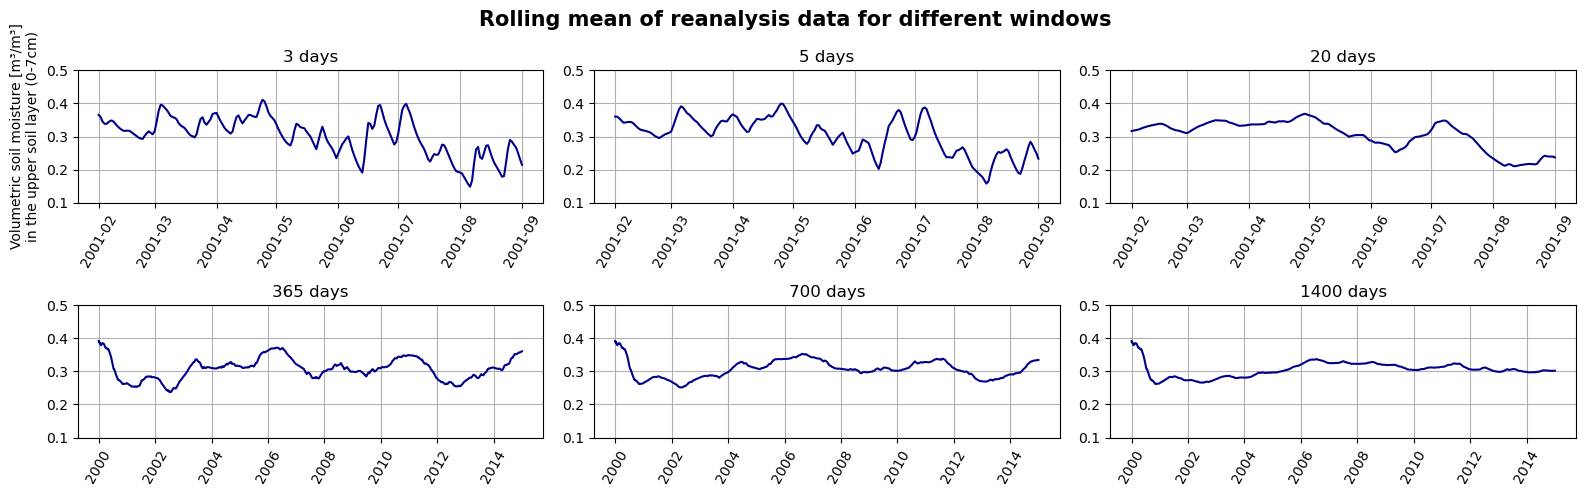

In [12]:
# Rolling mean

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize=(16,5))

for i, days in enumerate([3,5,20]):
    rolling_mean = reanalysis_daily["swvl1"].rolling(days, min_periods=1).mean().loc['2001-02-01':'2001-09-01']
    ax[0,i].plot(rolling_mean.index,rolling_mean, c = 'darkblue')
    ax[0,i].set_title(f'{days} days')
    ax[0,i].tick_params(axis='x', rotation=60)
    ax[0,i].set_ylim(ymin, ymax)
    ax[0,i].grid()

for i, days in enumerate([365,700,1400]):
    rolling_mean = reanalysis_daily["swvl1"].rolling(days, min_periods=1).mean().loc['2000-01-01':'2015-01-01']
    ax[1,i].plot(rolling_mean.index,rolling_mean, c = 'darkblue')
    ax[1,i].set_title(f'{days} days')
    ax[1,i].tick_params(axis='x', rotation=60)
    ax[1,i].set_ylim(ymin, ymax)
    ax[1,i].grid()

ax[0,0].set_ylabel("Volumetric soil moisture [m³/m³]\nin the upper soil layer (0-7cm)")
fig.suptitle('Rolling mean of reanalysis data for different windows', weight = 'bold', fontsize = 15)

plt.tight_layout()

<h2>1f. Correlation of ERA5 reanalysis soil moisture with other parameters

Parameter database for ERA5-Land: https://codes.ecmwf.int/grib/param-db/
- swvl1: volumetric soil water layer (0-7cm) [m³/m³]
- tp: total precipitation [m]
- skt: skin temperature (surface temperature) [K]
- stl: soil temperature (levels as with swvl) [K]
- evatc: evaporation from the top of canopy [m of water equivalent]
- pev: potential evaporation [m]
- swvl1_daily: daily mean of upper layer soil moisture (own computation) [m³/m³]

Text(0.5, 0.98, "Linear and monotonous correlation of 'swvl1' with other parameters")

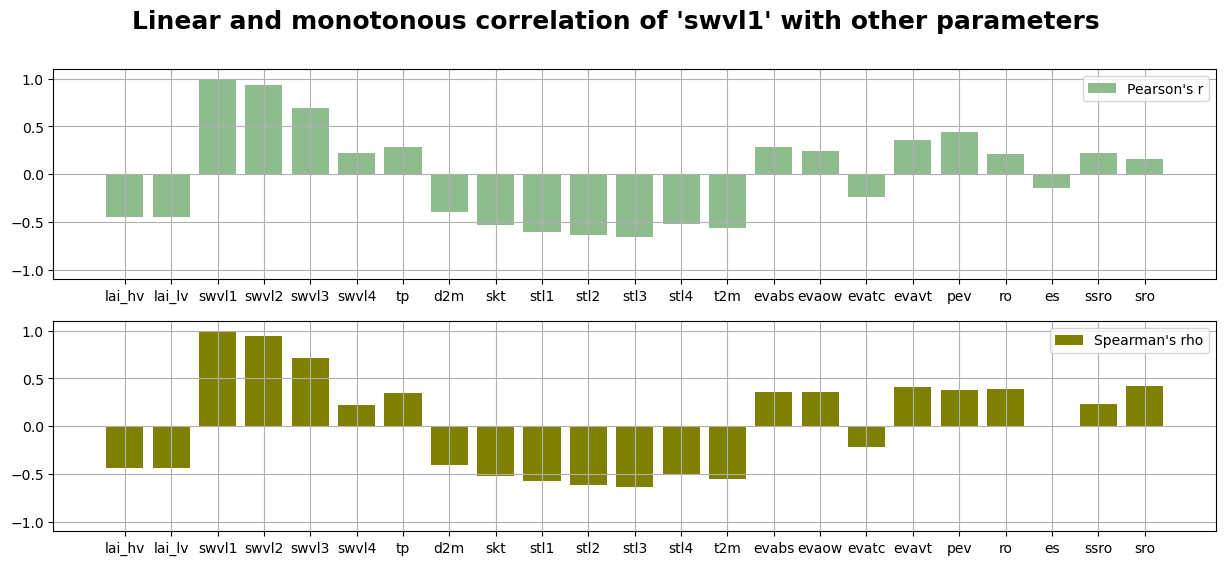

In [13]:
# Reanalysis data

pearson_df = []
spearman_df = []

for param in reanalysis.columns:

    mask = ~np.isnan(reanalysis["swvl1"]) & ~np.isnan(reanalysis[param])  # make sure to take out all nans before the correlation computation
    
    pearsonr = scipy.stats.pearsonr(reanalysis["swvl1"].values[mask], reanalysis[param].values[mask])[0]
    spearmanr = scipy.stats.spearmanr(reanalysis["swvl1"].values[mask], reanalysis[param].values[mask])[0]

    pearson_df.append(pearsonr)
    spearman_df.append(spearmanr)

fig, ax = plt.subplots(2,1, figsize = (15,6))

ax[0].bar(reanalysis.columns, pearson_df, color = 'darkseagreen', label = 'Pearson\'s r')
ax[0].grid()
ax[0].legend()
ax[0].set_ylim(-1.1, 1.1)

ax[1].bar(reanalysis.columns, spearman_df, color = 'olive', label = 'Spearman\'s rho')
ax[1].grid()
ax[1].legend()
ax[1].set_ylim(-1.1, 1.1)

fig.suptitle('Linear and monotonous correlation of \'swvl1\' with other parameters', weight = 'bold', fontsize = 18)

<h2>1g. Testing for stationarity and autocorrelation (reanalysis data)

In [14]:
# Testing for stationarity via Augumented-Dickey Fuller Test
result = adfuller(reanalysis_daily["swvl1"])
print("Test statistic: ", result[0])
print("p value:", result[1])


# Only if the p-value were to be close to significant, the critical values should be used to judge the hypothesis rejection
print("Critical values:")
for key, value in result[4].items():
    print(f"{key}: {round(value,3)}")

Test statistic:  -9.821514185320092
p value: 5.322674974424344e-17
Critical values:
1%: -3.431
5%: -2.862
10%: -2.567


/Users/wpreimes/miniforge3/envs/ml_lecture/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3057: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/wpreimes/miniforge3/envs/ml_lecture/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/wpreimes/miniforge3/envs/ml_lecture/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


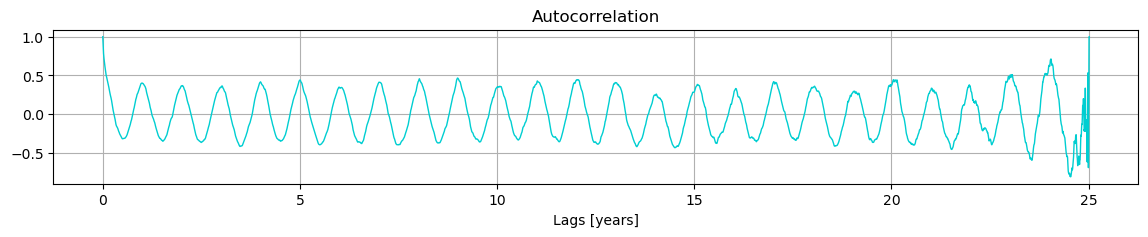

In [15]:
lags = np.arange(0,len(reanalysis_daily))
autocorrs = [reanalysis_daily["swvl1"].autocorr(lag=lag) for lag in lags]
fig, ax = plt.subplots(figsize=(14,2))
ax.plot(lags/365, autocorrs, linewidth=1, color = 'darkturquoise')
ax.set_xlabel("Lags [years]")
ax.set_title("Autocorrelation")
ax.grid()

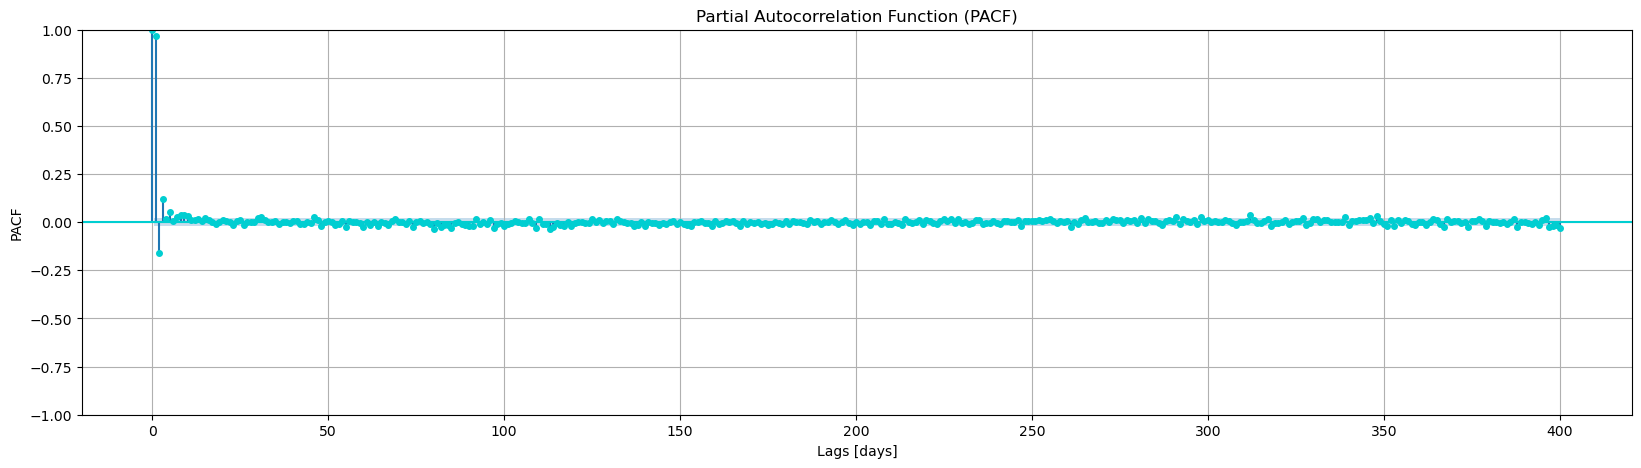

In [16]:
# Partial autocorrelation
nlags = 400
pacf_values = pacf(reanalysis_daily["swvl1"], nlags=nlags)

# Plot PACF
fig, ax = plt.subplots(figsize = (20,5))
plot_pacf(reanalysis_daily["swvl1"], lags=nlags, ax = ax, markersize=4, color = 'darkturquoise')
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lags [days]')
plt.ylabel('PACF')
plt.grid(True)
plt.show()

<h2>1h. Satellite data gap analysis

Text(0.5, 1.0, 'Soil moisture satellite time series at location Romania_lat=44.47617_lon=23.1129)')

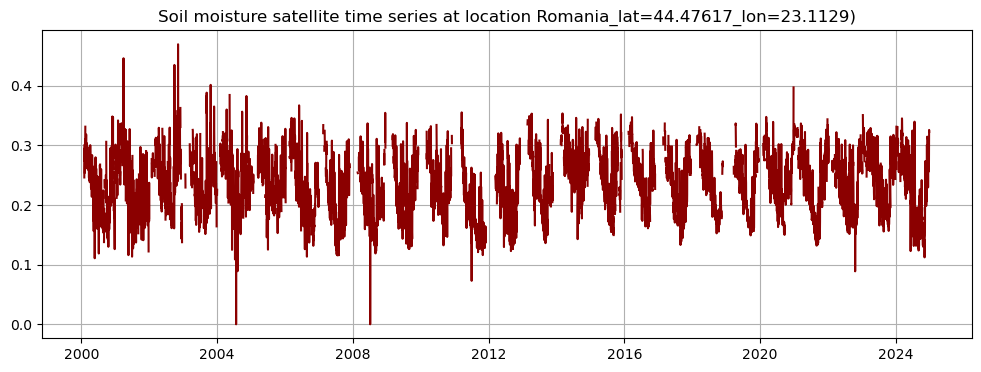

In [17]:
fig, ax = plt.subplots(1,1,figsize = (12,4))
ax.plot(satellite['sm'], c = 'darkred')
ax.grid()
ax.set_title(f'Soil moisture satellite time series at location {location})')

In [18]:
data_gap_list = []
data_gap_dates = []
gap = 0

if math.isnan(satellite['sm'].iloc[0]):
    gap = 1
else:
    gap = 0

for i in range(1,len(satellite['sm'].iloc[1:])):   
    
    if math.isnan(satellite['sm'].iloc[i]):
        gap += 1
    else:
        continue

    if math.isnan(satellite['sm'].iloc[i+1]):
        continue
    else:
        data_gap_list.append(gap)
        data_gap_dates.append(satellite.index[i-gap+1])
        gap = 0

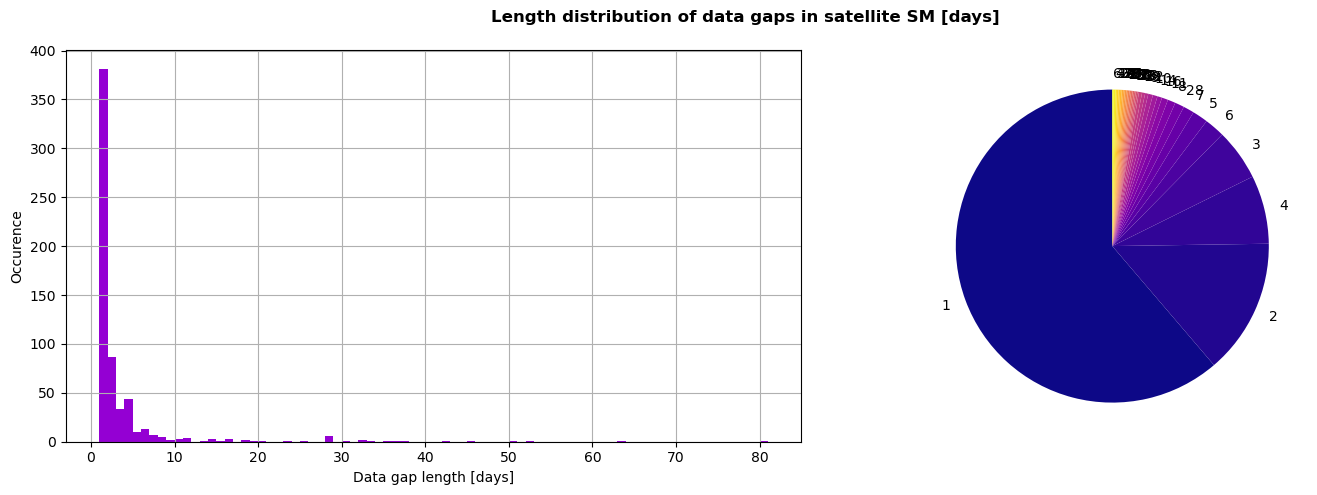

In [19]:
gaps_df = pd.DataFrame(data = {'data_gaps':data_gap_list}, index = data_gap_dates)

fig, ax = plt.subplots(1,2,figsize = (15,5))
ax[0].hist(gaps_df['data_gaps'], bins = np.max(gaps_df['data_gaps'])-1, color = 'darkviolet')
ax[0].grid()
ax[0].set_ylabel('Occurence')
ax[0].set_xlabel('Data gap length [days]')

colors = plt.cm.plasma(np.linspace(0, 1, len(gaps_df['data_gaps'].value_counts())))

ax[1].pie(
    gaps_df['data_gaps'].value_counts(),
    labels=gaps_df['data_gaps'].value_counts().index,
    #autopct='%1.1f%%',
    startangle=90,
    colors = colors
)

fig.suptitle("Length distribution of data gaps in satellite SM [days]", weight = 'bold')
fig.tight_layout()

In [20]:
print('arithmetic mean of data gap length: ', np.mean(data_gap_list))
print('median of data gap length: ', np.median(data_gap_list))
print('min of data gap length: ', np.min(data_gap_list))
print('max of data gap length: ', np.max(data_gap_list))
print('number of consecutive data gaps: ', len(data_gap_list))
print('number of data gaps (total days with missing data): ', len(satellite[satellite['sm'].isna()]))

arithmetic mean of data gap length:  3.401929260450161
median of data gap length:  1.0
min of data gap length:  1
max of data gap length:  81
number of consecutive data gaps:  622
number of data gaps (total days with missing data):  2117


Text(0.5, 0.98, 'Temporal distribution of data gaps in satellite SM measurements')

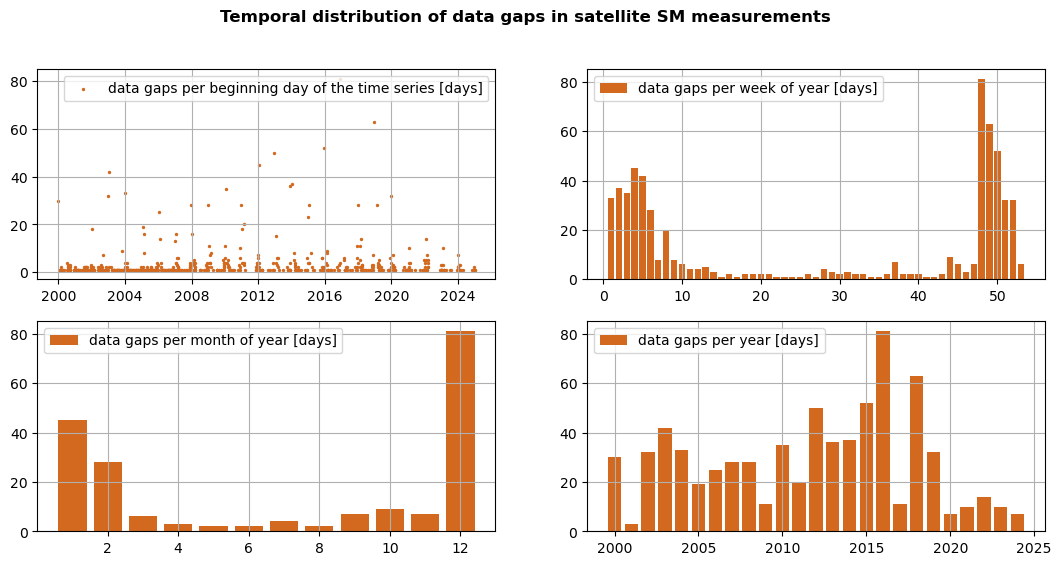

In [21]:
gaps_df['month'] = gaps_df.index.month
gaps_df['weekofyear'] = gaps_df.index.isocalendar().week
gaps_df['year'] = gaps_df.index.year


fig, ax = plt.subplots(2,2, figsize = (13,6))

ax[0,0].scatter(gaps_df.index, gaps_df['data_gaps'], color = 'chocolate', label = 'data gaps per beginning day of the time series [days]', s = 2)
ax[0,1].bar(gaps_df['weekofyear'], gaps_df['data_gaps'], color = 'chocolate', label = 'data gaps per week of year [days]')
ax[1,0].bar(gaps_df['month'], gaps_df['data_gaps'], color = 'chocolate', label = 'data gaps per month of year [days]')
ax[1,1].bar(gaps_df['year'], gaps_df['data_gaps'], color = 'chocolate', label = 'data gaps per year [days]')

for i in range(2):
    for j in range(2):
        ax[i,j].grid()
        ax[i,j].legend()

fig.suptitle('Temporal distribution of data gaps in satellite SM measurements', weight = 'bold')

In [28]:
pd.DataFrame(index=data_gap_dates, data=data_gap_list)

,0
2000-01-01,30
2000-02-01,1
2000-02-04,1
2000-02-07,1
2000-02-14,1
...,...
2024-12-10,1
2024-12-12,1
2024-12-19,2
2024-12-27,1


Text(0.5, 0.98, 'Temporal distribution of average data gap length in satellite SM measurements')

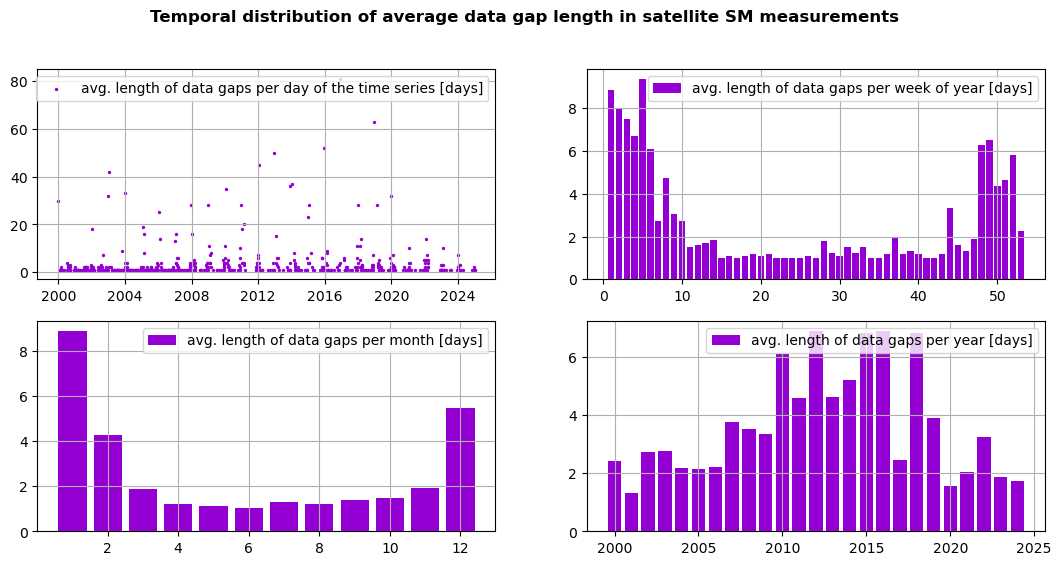

In [22]:
fig, ax = plt.subplots(2,2, figsize = (13,6))

ax[0,0].scatter(data_gap_dates, data_gap_list, color = 'darkviolet', label = 'avg. length of data gaps per day of the time series [days]', s = 2)
ax[0,1].bar(gaps_df.groupby('weekofyear').mean().index, gaps_df.groupby('weekofyear').mean()['data_gaps'], color = 'darkviolet', label = 'avg. length of data gaps per week of year [days]')
ax[1,0].bar(gaps_df.groupby('month').mean().index, gaps_df.groupby('month').mean()['data_gaps'], color = 'darkviolet', label = 'avg. length of data gaps per month [days]')
ax[1,1].bar(gaps_df.groupby('year').mean().index, gaps_df.groupby('year').mean()['data_gaps'], color = 'darkviolet', label = 'avg. length of data gaps per year [days]')

for i in range(2):
    for j in range(2):
        ax[i,j].grid()
        ax[i,j].legend()

fig.suptitle('Temporal distribution of average data gap length in satellite SM measurements', weight = 'bold')